In [ ]:
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm,trange
import torch.nn as nn


In [ ]:
df=pd.read_csv('100計數_地段率.csv',encoding='UTF-8')

In [ ]:
data=np.zeros((141,132,28))
label=np.zeros((141,132,1))
for x in range(len(data)):
    for y in range(len(data[0])):
        id=141*y+x
        datadict={
            0:'活動中心',
            1:'郵局',
            2:'公車站',
            3:'火車站',
            4:'加油站',
            5:'停車場',
            6:'腳踏車',
            7:'寺廟',
            8:'大賣場',
            9:'服飾',
            10:'便利商店',
            11:'超市美妝',
            12:'電子賣場',
            13:'銀行',
            14:'ATM',
            15:'大學',
            16:'高中',
            17:'國小',
            18:'國中',
            19:'補習班',
            20:'嫌惡設施_危險',
            21:'嫌惡設施_殯葬',
            22:'嫌惡設施_髒亂',
            23:'食物',
            24:'診所',
            25:'醫院',
            26:'禮品百貨',
            27:'觀光景點',
        }
        label[x][y][0]=df.iloc[id]['平均地段率']
        for i in range(28):
            data[x][y][i]=df.iloc[id][datadict[i]]


In [ ]:


validnum=len(df[df['平均地段率']>0.1])
print(validnum)
validdata=np.zeros((len(df[df['平均地段率']>0.1]),28,11,11))
validlabel=np.zeros((len(df[df['平均地段率']>0.1]),1))
counter=0
for y in trange(len(data[0])):
    for x in range(len(data)):
        if label[x][y][0]>0.5:
            for i in range(28):
                tempx=x-5
                tempy=y-5
                for a in range(11):
                    for b in range(11):
                        try:
                            validdata[counter][i][a][b]+=data[tempx+a][tempy+b][i]
                        except:
                            continue
            validlabel[counter][0]=label[x][y][0]-80    
            counter=counter+1



            

2671


  0%|          | 0/132 [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import Dataset, DataLoader
class ExampleDataset(Dataset):

    # data loading
    def __init__(self,tr,target, length):
        
        self.x = tr.astype(np.float32)
        self.y = target.astype(np.float32)
        self.n_samples = length

    # working for indexing
    def __getitem__(self, index):
        
        return self.x[index], self.y[index]

    # return the length of our dataset
    def __len__(self):
        
        return self.n_samples

In [ ]:
tr0_set=ExampleDataset(validdata[0:2200],validlabel[0:2200],2200)
dataloader = DataLoader(tr0_set, batch_size=20, shuffle=True)
val_set=ExampleDataset(validdata[2200:],validlabel[2200:],(len(validdata)-2200))
dataloader_val = DataLoader(val_set, batch_size=20, shuffle=False)

In [ ]:
import torch.nn as nn
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self):
        super(NeuralNet, self).__init__()
        # self.cv2_1=nn.Conv2d(28, 64, 3, stride=1)
        # self.cv2_2=nn.Conv2d(64, 128, 3, stride=1)
        # self.cv2_3=nn.Conv2d(128, 256, 5, stride=1)

        # self.layer1 = nn.Linear(3*3*256, 128)
        # self.layer2 = nn.Linear(128, 32)
        # self.out = nn.Linear(32, 1) 

        # self.ba1=nn.BatchNorm1d(256)
        # self.ba2=nn.BatchNorm1d(128)

        # self.act_fn1 = nn.ReLU()
        # self.act_fn2 = nn.ReLU()
        # self.act_fn3 = nn.ReLU()
        # self.act_fn4 = nn.ReLU()
        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Conv2d(28, 64, 3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, 5, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(5*5*256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1) 
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        out=self.net(x)
        
        return out

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        lamb = 0.0003
        if lamb :
          l2_reg = torch.tensor(0.).to('cuda')
          for param in self.parameters() :
            l2_reg += torch.norm(param)
          return self.criterion(pred, target) + l2_reg*lamb
        else : 
          return self.criterion(pred, target)

In [ ]:
import torch.optim as optim

def train(tr_set, val_set, model, device):
    ''' DNN training '''
    criterion = nn.MSELoss()
    n_epochs = 50  # Maximum number of epochs
    best_loss = 0.0
    # Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=1E-3,weight_decay=0.00002)   

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    best_loss = 100000.0
    while epoch < n_epochs:
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, labels = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            outputs = model(x)                     # forward pass (compute output)
            mse_loss = criterion(outputs, labels)  # compute loss
            _, train_pred = torch.max(outputs, 1)
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            train_loss += mse_loss.item()

        # After each epoch, test your model on the validation (development) set.
        if len(val_set) > 0:
            model.eval() # set the model to evaluation mode
            with torch.no_grad():
                for i, data in enumerate(val_set):
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    batch_loss = criterion(outputs, labels) 
                    _, val_pred = torch.max(outputs, 1) 
                    an= torch.max(labels) 
                    val_loss += batch_loss.item()

                print('[{:03d}/{:03d}]  Loss: {:3.6f} | loss: {:3.6f}'.format(
                    epoch + 1, n_epochs, train_loss/len(tr_set),  val_loss/len(val_set)
                ))

                # if the model improves, save a checkpoint at this epoch
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(model, "D:\程式\google map api\model_cnn.pth")
                    print('saving model with loss {:.3f}'.format(best_loss/len(val_set)))
        else:
            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
                epoch + 1, n_epochs, train_loss/len(tr_set), train_loss/len(tr_set)
            ))
        epoch += 1
    # if not validating, save the last epoch
    if len(val_set) == 0:
        torch.save(model, 'model.pth')
        print('saving model at last epoch')

    return min_mse, loss_record

In [ ]:
model = NeuralNet().to('cuda')  # Construct model and move to device
model_loss, model_loss_record = train(dataloader, dataloader_val, model, 'cuda')

[001/150]  Loss: 332.523029 | loss: 92.370090
saving model with loss 92.370
[002/150]  Loss: 73.127833 | loss: 75.918953
saving model with loss 75.919
[003/150]  Loss: 64.624662 | loss: 74.794698
saving model with loss 74.795
[004/150]  Loss: 59.932119 | loss: 69.838322
saving model with loss 69.838
[005/150]  Loss: 50.684487 | loss: 62.200530
saving model with loss 62.201
[006/150]  Loss: 48.908293 | loss: 74.767385
[007/150]  Loss: 43.470628 | loss: 70.640494
[008/150]  Loss: 40.807780 | loss: 72.228680
[009/150]  Loss: 41.860346 | loss: 71.851498
[010/150]  Loss: 36.255664 | loss: 74.895319
[011/150]  Loss: 31.420035 | loss: 75.108617
[012/150]  Loss: 26.487556 | loss: 82.869577
[013/150]  Loss: 25.732853 | loss: 83.623973
[014/150]  Loss: 23.612695 | loss: 84.330126
[015/150]  Loss: 18.428012 | loss: 96.701930
[016/150]  Loss: 16.475140 | loss: 95.240240
[017/150]  Loss: 15.029840 | loss: 111.296583
[018/150]  Loss: 12.498720 | loss: 99.843342
[019/150]  Loss: 10.441455 | loss: 99.

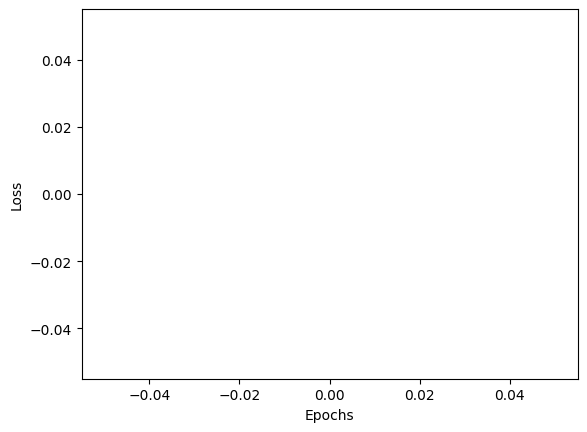

In [ ]:


import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(model_loss_record['train'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

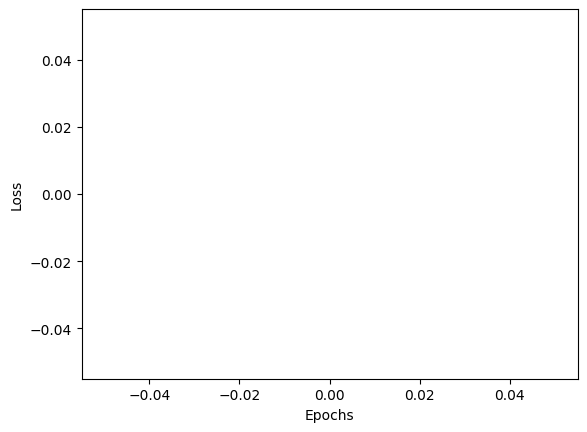

In [ ]:
import matplotlib.pyplot as plt

plt.ion()

fig = plt.figure()
plt.plot(model_loss_record['train'][5:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
fig.savefig('train100loss.jpg')

In [ ]:

model=torch.load("D:\程式\google map api\model_cnn.pth")
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

count=0
prd_err=[]
tt_set = DataLoader(validdata.astype(np.float32), batch_size=1, shuffle=False)
preds = test(tt_set, model, 'cuda')  # predict COVID-19 cases with your model
for i in range(len(preds)):
    if preds[i] - validlabel[i] > 10 or preds[i] - validlabel[i] < -10:
        print("實際值:",validlabel[i],"預測結果:",preds[i],"id:",i)
        count+=1
        prd_err.append(i)


print("預測錯誤數量:",count)
prd_err=pd.DataFrame(prd_err)
prd_err.to_csv("prd_err_cnn.csv",index=False)



實際值: [20.] 預測結果: [34.73747] id: 9
實際值: [20.] 預測結果: [34.25507] id: 10
實際值: [20.] 預測結果: [34.25624] id: 11
實際值: [20.] 預測結果: [32.6194] id: 12
實際值: [20.] 預測結果: [32.864277] id: 13
實際值: [20.] 預測結果: [32.799156] id: 14
實際值: [20.] 預測結果: [32.346462] id: 15
實際值: [20.] 預測結果: [32.324055] id: 16
實際值: [20.] 預測結果: [32.17127] id: 17
實際值: [20.] 預測結果: [32.983097] id: 21
實際值: [20.] 預測結果: [32.01809] id: 22
實際值: [20.] 預測結果: [31.685392] id: 23
實際值: [20.] 預測結果: [31.43438] id: 24
實際值: [20.] 預測結果: [31.578375] id: 25
實際值: [20.] 預測結果: [31.90703] id: 26
實際值: [20.] 預測結果: [32.296566] id: 27
實際值: [20.] 預測結果: [32.214764] id: 32
實際值: [20.] 預測結果: [31.886995] id: 33
實際值: [20.] 預測結果: [31.854221] id: 34
實際值: [20.] 預測結果: [31.81578] id: 35
實際值: [20.] 預測結果: [32.028793] id: 36
實際值: [20.] 預測結果: [32.145626] id: 37
實際值: [20.] 預測結果: [32.184658] id: 43
實際值: [20.] 預測結果: [32.413837] id: 44
實際值: [20.] 預測結果: [34.25963] id: 45
實際值: [20.] 預測結果: [35.34054] id: 49
實際值: [20.] 預測結果: [35.139606] id: 50
實際值: [20.] 預測結果: [35.002434] id: 51
實際值: 

In [ ]:
#real data(all)


realdata=np.zeros((len(df['id']),28,11,11))
reallabel=np.zeros((len(df['id']),1))
counter=0
for y in trange(len(data[0])):
    for x in range(len(data)):
        for i in range(28):
            tempx=x-5
            tempy=y-5
            for a in range(11):
                for b in range(11):
                    try:
                        realdata[counter][i][a][b]+=data[tempx+a][tempy+b][i]
                    except:
                        continue
        reallabel[counter][0]=label[x][y][0]-80    
        counter=counter+1
tt_set = DataLoader(realdata.astype(np.float32), batch_size=1, shuffle=False)
preds = test(tt_set, model, 'cuda')  # predict COVID-19 cases with your model

  0%|          | 0/132 [00:00<?, ?it/s]

In [ ]:
import math
err=[]
pred=[]
for i in range(len(preds)):
    ##err.append(abs(preds[i][0]-reallabel[i][0]))
    pred.append(preds[i][0]+80)


In [ ]:
print(len(pred))

18612


In [ ]:

df['預測值']=pred
df.to_csv('result100all_cnn.csv')

In [ ]:
import json
with open('100計數_地段率.geojson', newline='',encoding="utf-8") as jsonfile:
    data = json.load(jsonfile)

for i in range(len(preds)):
    data['features'][i]['properties']['預測值']=pred[i]

print(data['features'][0]['properties'])
with open('100計數_地段率_preds_cnn.geojson', 'w',encoding="utf-8") as json_obj:
    json.dump(data, json_obj, ensure_ascii = False, indent=4)




with open('100計數_地段率_preds_cnn.geojson', newline='',encoding="utf-8") as jsonfile2:
    data2 = json.load(jsonfile2)
print(data2['features'][0]['properties'])

{'id': 1.0, 'left': 13373240.3256, 'top': 2635136.2672999995, 'right': 13373340.325599998, 'bottom': 2635036.2673, '活動中心': 0.0, '郵局': 0.0, '公車站': 0.0, '火車站': 0.0, '加油站': 0.0, '停車場': 0.0, '腳踏車': 0.0, '寺廟': 0.0, '大賣場': 0.0, '服飾': 0.0, '便利商店': 0.0, '超市美妝': 0.0, '電子賣場': 0.0, '銀行': 0.0, 'ATM': 0.0, '大學': 0.0, '高中': 0.0, '國小': 0.0, '國中': 0.0, '補習班': 0.0, '嫌惡設施_危險': 0.0, '嫌惡設施_殯葬': 0.0, '嫌惡設施_髒亂': 0.0, '食物': 0.0, '診所': 0.0, '醫院': 0.0, '禮品百貨': 0.0, '觀光景點': 0.0, '房屋稅數量': 0.0, '地段率總和': 0.0, '折舊年數總和': 0.0, '平均地段率': None, '平均折舊年數': None, 'EPSG3857_X': 13373290.325599998, 'EPSG3857_Y': 2635086.2672999995, '預測值': 118.66514587402344}
{'id': 1.0, 'left': 13373240.3256, 'top': 2635136.2672999995, 'right': 13373340.325599998, 'bottom': 2635036.2673, '活動中心': 0.0, '郵局': 0.0, '公車站': 0.0, '火車站': 0.0, '加油站': 0.0, '停車場': 0.0, '腳踏車': 0.0, '寺廟': 0.0, '大賣場': 0.0, '服飾': 0.0, '便利商店': 0.0, '超市美妝': 0.0, '電子賣場': 0.0, '銀行': 0.0, 'ATM': 0.0, '大學': 0.0, '高中': 0.0, '國小': 0.0, '國中': 0.0, '補習班': 0.0, '嫌惡設施_危險': 0.0, '嫌惡設施_